# The Hidden Validation Set You Might Not Be Using

I love Random Forests. Really, I love all decision tree based models.  The concept of learning by partitioning is simple and intuitive and is easy to reason about when you’re trying to understand how a model might be “seeing” your data.

For me, unless it’s not a good match for the dataset, a Random Forest is the way I like to start playing around with a dataset.

One of the reasons is that some random forest implementations have a built-in validation set of sorts.  If you’re not familiar with “out of bag” validation, it’s an excellent addition to your ML development toolkit that I find is underutilized.  In fact – I almost never run into anybody else who regularly uses it!

Check out this notebook in which we explore how the out-of-bag validation can speed up your workflow and potentially even give you a more accurate estimate of model performance than your k-fold cross-validation at a fraction of the computational cost!

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
rf_params = dict(n_jobs=-1, n_estimators=256, min_samples_leaf=20)

In [3]:
def generate_toy_dataset(n_train):
    # Generating an unbalanced dataset
    X, y = make_regression(
        n_samples=n_train,
        n_features=30,
        n_informative=5,
        effective_rank=12,
        tail_strength=0.5,
        noise=10.0,
        random_state=42
    )
    df = pd.DataFrame(X)
    df.columns = df.columns.astype(str)
    _X = df.columns
    _y = 'target'
    df[_y] = y
    return df, _X, _y

df, _X, _y = generate_toy_dataset(n_train=1000)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,target
0,-0.032432,-0.013066,0.004673,-0.017611,0.035532,-0.014728,-0.014885,-0.005247,0.003580,-0.008661,...,-0.007763,0.016018,-0.017136,-0.025479,-0.038388,-0.032405,-0.004957,-0.005976,-0.016520,-1.007347
1,0.008624,-0.032773,-0.020031,0.020145,-0.006798,0.003736,0.023822,-0.040737,0.025638,-0.004040,...,-0.031387,-0.014356,0.001716,0.038014,0.016288,0.008245,-0.004310,0.001984,0.016031,16.710669
2,-0.015039,0.034703,0.031771,0.001136,-0.000144,0.041739,-0.010032,0.005467,0.003280,0.015583,...,-0.001197,0.028461,-0.032698,-0.021573,0.013873,0.024355,-0.015747,0.005714,0.021787,-4.883995
3,0.009395,0.024268,-0.031028,-0.029758,-0.040502,0.029972,0.011669,0.017631,-0.034498,0.003571,...,0.005521,-0.001306,-0.009699,-0.007910,0.025553,-0.048658,-0.008468,0.045984,0.004110,-3.864474
4,0.003794,0.009415,0.006692,-0.012750,-0.013199,-0.006064,0.015940,0.023851,0.017628,-0.001793,...,0.010429,-0.000769,-0.037190,0.039113,0.005426,-0.007129,0.001969,0.004865,-0.020894,6.945772


# Bootstrapping and the Out of Bag Sample

By default in scikit-learn, the Random Forest Regressor uses boostrap sampling.  That is, if you feed in "n" samples, every decision tree in the forest is trained on "n" samples chosen with replacement from the original "n".  

Since the sampling happens with replacement, there will almost always be some samples left out of training on each tree.  Those rows are described as being "out of bag".

The "out of bag" sample is interesting because it has the properties of a randomly selected validation set.  For each estimator added to the forest we have a "free" validation set sitting there which can be used in a manner similar to other forms of validation like "leave one out" or "k-fold cross validation".

# oob_prediction

We can form a prediction for the out of bag samples simply by feeding them into the decision tree that was trained during the round in which they were left out of training.

These predictions are generated for each estimator, so in general each sample will have many out-of-bag predictions.

The standard way of producing a prediction from a random forest is to feed a sample into each decision tree, get a prediction from each, and then average all of the predictions together.In a similar way, we can form an "out-of-bag prediction" for each sample in the training set by averaging together all of the individual out-of-bag predictions for that sample.  

Since a given sample was never involved in the training of the tree that produces its out of bag prediction, the out-of-bag prediction can provide an estimate of generalization to unseen samples. In fact, it can be proven that the out-of-bag prediction is in general a *slightly pessimistic* evaluation of generalization performance.

# The oob_prediction is like having a "free" set of cross-validation predictions

The best thing about the oob_prediction is that it comes "for free" (small computational cost) as long as you ask for it, simply by specifying "oob_score=True". 

Do that and train the model and you'll be given access to "oob_prediction" which you can use to compute out-of-bag statistics which are very similar to cross validation statistics.  


In [4]:
RandomForestRegressor(oob_score=True, **rf_params)

RandomForestRegressor(min_samples_leaf=20, n_estimators=256, n_jobs=-1,
                      oob_score=True)

# Compare oob to xval

I'd like to argue that OOB Validation is simply generally better than KFold Cross Validation

Why it's better:
- it's easier and simpler to code up. 
- it's more precise (performance metric estimates have less variation)
- train only 1 model instead of k models.  It's k times faster!  really it's k+1 times faster!

In addition, there are downstream tasks like stacking, calibration, and potentially more - which are easier to do with OOB predictions than with a kfold-based approach.

# The code is simpler than kfold

The code is just easier to write.  I don't know about you - but for me there's always a little bit of mental overhead or boilerplate in setting up a kfold loop or using a cross-val convenience wrapper.  OOB just totally eliminates that.

No loops, no cross-val wrappers - just a single extra param and you've got your OOB predictions ready to go!

In [5]:
def oob_mse(additional_rf_params={}):
    model = RandomForestRegressor(oob_score=True, **{**rf_params, **additional_rf_params})
    P = model.fit(df[_X], df[_y]).oob_prediction_ #boom - one and done
    return mean_squared_error(P, df[_y])

### Compare to Kfold

Compare to using "KFold" + manually indexing folds:

In [6]:
from sklearn.model_selection import KFold
def kfold_mse(n_folds):
    mses = []
    for train_index, val_index in KFold(n_splits=n_folds, random_state=None, shuffle=True).split(df):
        X_train = df.loc[train_index, _X]
        y_train = df.loc[train_index, _y]
        X_val   = df.loc[val_index, _X]
        y_val   = df.loc[val_index, _y]
        model = RandomForestRegressor(oob_score=False, **rf_params)
        P_val = model.fit(X_train, y_train).predict(X_val)
        mses.append(mean_squared_error(P_val, y_val))
    return np.mean(mses)

There's a lot to track here in terms of indexing etc. 

To be fair, there are things you can do with this approach that you can't do with the OOB technique.  For example: stratified sampling. 

### Compare to Xval Convenience Wrapper

Or compare to scikit-learn's cross validation convenience functions which can be less elegant and less flexible than the OOB approach:

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
def sklearn_cv_mse(n_folds):
    mse = make_scorer(mean_squared_error)
    model = RandomForestRegressor(oob_score=False, **rf_params)
    cv_results = cross_validate(model, df[_X], df[_y], cv=n_folds, scoring=mse) 
    return np.mean(cv_results['test_score'])

In this example you need to remember to make your own "mean_squared_error" scorer using "make_scorer" or you have to feed in "neg_mean_squared_error" which results in the output score being negative.

It's a bit awkward!  

I went with making my own scorer to avoid any downstream effects from potentially forgetting to negate the output of cv_results['test_score'] (for example - accidentally selecting the worst model instead of the best model from a hyperparam search).

Even the somewhat streamlined cross_validate convenience function isn't as clean, simple, and terse as the OOB validation method.

It's not a huge difference on its own but efficiencies in code add up!

# OOB Validation is more precise than kfold cross-validation

Let's measure the precision of out of bag validation compared to kfold cross validation .

We'll do this by repeatedly running en experiment in which we compute a validation statistic (mean squared error) and then analyze the variation of that statistic across repeated runs.

In [8]:
from tqdm.notebook import tqdm
def oob_vs_kfold():
    n_experiment_rounds = 50
    
    oob_mses      = [oob_mse() for _ in tqdm(range(n_experiment_rounds))]
    kfold_mses_3  = [kfold_mse(n_folds=3)  for _ in tqdm(range(n_experiment_rounds))]
    kfold_mses_5  = [kfold_mse(n_folds=5)  for _ in tqdm(range(n_experiment_rounds))]
    kfold_mses_10 = [kfold_mse(n_folds=10) for _ in tqdm(range(n_experiment_rounds))]
    kfold_mses_20 = [kfold_mse(n_folds=20) for _ in tqdm(range(n_experiment_rounds))]
    
    
    mses = pd.DataFrame(dict(oob=oob_mses, 
                             kfold_3=kfold_mses_3,
                             kfold_5=kfold_mses_5,
                             kfold_10=kfold_mses_10,
                             kfold_20=kfold_mses_20
                            ))
    
    return mses
    
mses = oob_vs_kfold()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
mses

,oob,kfold_3,kfold_5,kfold_10,kfold_20
0,102.110971,103.060098,101.085444,102.073909,101.998807
1,101.022619,102.709733,102.639982,102.497740,101.651983
2,101.648983,103.129879,102.558203,102.213468,102.560787
3,102.594244,102.191084,102.127463,102.531201,101.694535
4,101.965452,102.226510,102.920187,102.394298,100.974318
5,102.371856,103.008761,100.967999,102.697971,102.574012
6,101.722242,102.197245,102.381607,102.302552,101.819739
7,102.018081,105.210680,101.801356,102.434838,101.776994
8,102.551499,103.298293,103.370401,101.610504,101.526712
9,102.106540,101.540208,102.179012,101.872759,102.295598


In [10]:
mses.agg(['mean', 'std', 'min', 'max'])

,oob,kfold_3,kfold_5,kfold_10,kfold_20
mean,102.099474,102.285181,102.109004,102.113874,101.840059
std,0.320546,0.930227,0.706919,0.546338,0.410853
min,101.022619,99.941000,99.978404,100.864469,100.974318
max,102.594244,105.210680,103.370401,103.613903,102.574012


<AxesSubplot:ylabel='Frequency'>

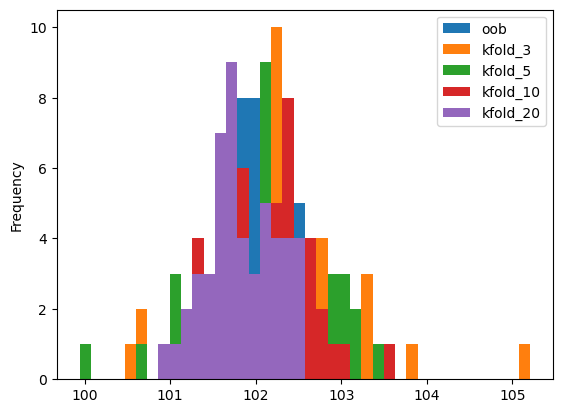

In [11]:
mses.plot(kind='hist', bins=40)

You can see from these stats as well as the histogram that each of these methods converge on a very similar estimate of the mean squared error.

However, the out of bag estimate exhibits lower variance than each of the kfold methods.

While tuning a model - those kinds of swings in the estimation of the model performance can have an influence on hyperparameter decisions.  

# OOB Validation is WAY Faster than KFold XVal

At 20 folds, our kfold estimate of the MSE comparable variation to our OOB estimate - and it takes 20 times as long to compute!

In general, you can think of OOB validation as only requiring "1x" computation while kfold cross validation requires "kx"- that is, it takes k times as long or k times as much compute.

That can be a HUGE difference in compute time.

If you want to squeeze all you can out of your model while tuning, out of bag is often a superior option - being either much more stable than comparably fast kfold estimates (though it's still more than twice as fast as 3-fold x-val), or an order of magnitude faster than comparably stable kfold estimates.

The impact of this can't be overestimated - having your experiments run 2-20x faster can be transformative in terms of your ability to iterate on a model.

# Bonus 1: One more time!

In addition, you'll probably want to retrain the model one more time after performing kfold x-val.  This is because your kfold models will each have only been trained on a subset of the data.  

You could just use one of the models from one of the folds, but depending on how many folds you've chosen you might be missing out on e.g. 33%, 25%, 20% etc of the dataset. That's usually enough to make a difference.

This isn't necessarily the case with OOB.  If you know what hyperparams you're using (or you have the model sitting around after training), it's already trained after having performed OOB validation - there's no need to train it again.  It's already been trained on all of the data.

# Bonus 2: Its even more precise as you crank up the number of estimators

As you add estimators, you get more "out of bag folds" so your OOB performance estimates become more precise.

Adding estimators also linearly increases the training time - which makes the added speed of OOB methods that much more crucial when you're tuning a model with a large number of trees

In [12]:
from tqdm.notebook import tqdm
def oob_vs_n_estimators():
    n_experiment_rounds = 10
    
    oob_mses_16 = [oob_mse(dict(n_estimators=16)) for _ in tqdm(range(n_experiment_rounds))]
    oob_mses_64 = [oob_mse(dict(n_estimators=64)) for _ in tqdm(range(n_experiment_rounds))]
    oob_mses_256 = [oob_mse(dict(n_estimators=256)) for _ in tqdm(range(n_experiment_rounds))]
    
    mses = pd.DataFrame(dict(oob_16=oob_mses_16, 
                             oob_64=oob_mses_64,
                             oob_256=oob_mses_256
                            ))
    
    return mses
    
mses = oob_vs_n_estimators()
mses

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\padkins\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\padkins\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\padkins\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\padkins\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,oob_16,oob_64,oob_256
0,104.892203,104.096593,102.100955
1,105.889410,103.769406,102.387141
2,108.761226,103.107335,102.148795
3,107.913874,103.906723,101.808575
4,106.020240,103.632222,101.864493
5,106.482416,102.061029,102.014666
6,108.738301,102.935395,101.523997
7,109.016659,105.082479,101.723573
8,105.420502,103.368622,102.261296
9,108.932833,102.831308,102.726787


<AxesSubplot:title={'center':'standard deviation of mse estimate'}>

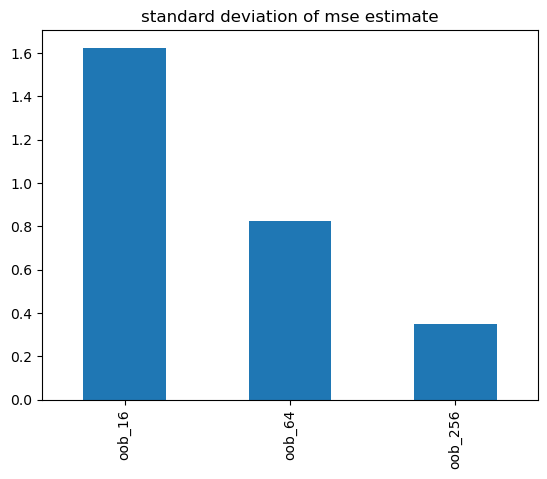

In [13]:
mses.std().plot(kind='bar', title='standard deviation of mse estimate')

# But wait ... there's more!

There are even more benefits to using OOB predictions.  We'll potentially discuss those in a future article...